In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
%matplotlib inline

In [3]:
# Import state vector file using geopandas
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

In [72]:
# Subset Parameters
# Slice/Subset data down further based on latitutde (-90 -- +90), longitude (0 -- 360)
lat_bnds, lon_bnds = [20, 55], [220, 260]

# Choose U, V, Ta, Hus files from the same time-period
fNameVa  = '/glade/scratch/currierw/ACCESS1-0/historical/va_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNameUa  = '/glade/scratch/currierw/ACCESS1-0/historical/ua_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNameTa  = '/glade/scratch/currierw/ACCESS1-0/historical/ta_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNameHus = '/glade/scratch/currierw/ACCESS1-0/historical/hus_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'

# open the datasets (ds) with xarray
vads  = xr.open_dataset(fNameVa)
uads  = xr.open_dataset(fNameUa) 
tads  = xr.open_dataset(fNameTa) 
husds = xr.open_dataset(fNameHus)

# Precipitation is not 4D, only time,lat,lon - stored in larger files in 3 hr data
fNamePrec='/glade/scratch/currierw/ACCESS1-0/historical/prc_3hr_ACCESS1-0_historical_r1i1p1_198001010130-198412312230.nc'

prcds = xr.open_dataset(fNamePrec)

print("Size of 3D Files \n")
print(prcds['prc'].shape)

# Slice/Subset 3D data
prcds_sub  = prcds.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds)) # Subset spatially first
prc6HrSub  = prc6hr.sel(time=slice(vads.time[0],vads.time[-1]))    # Time slice based on 6H data file
prc6hr     = prcds_sub['prc'].resample(time='6H').sum()            # Aggregate from 3H to 6H

# Check the size of all the files
# 1464 time-steps, 38 levels in the atmosphere, u v are staggered in lat/lon
print("\nSize of 4D Files \n")
print(vads['va'].shape)
print(uads['ua'].shape)
print(tads['ta'].shape)
print(husds['hus'].shape)

# Slice/Subset 4D data
vads_sub  = vads.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))  # subset the Va data spatially
uads_sub  = uads.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))  # subset the Ua data spatially

tads_sub  = tads.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))  # subset the ta data spatially
husds_sub = husds.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds)) # subset the hus data spatially

print("\nSize of all subsetted files \n")
print(vads_sub['va'].shape)
print(uads_sub['ua'].shape)
print(tads_sub['ta'].shape)
print(husds_sub['hus'].shape)
print(prc6HrSub.shape)

# Creating New Dataset
print("\nCreating new dataset\n")

# Create new coordiantes within the subsetted data
vads_sub['lat']=vads_sub.lat.rename({'lat':'lat_va'})
vads_sub['lon']=vads_sub.lon.rename({'lon':'lon_va'})

uads_sub['lat']=uads_sub.lat.rename({'lat':'lat_ua'})
uads_sub['lon']=uads_sub.lon.rename({'lon':'lon_ua'})

vads_sub['uv_lev']=vads_sub.lev.rename({'lev':'uv_lev'})
uads_sub['uv_lev']=uads_sub.lev.rename({'lev':'uv_lev'})

# Create New Datasets that's just the datasets with dimensions and coordinates

ds_orog = xr.Dataset({"orog":(("lat","lon"),tads_sub.orog)},
                 coords={"lat":tads_sub.lat,"lon":tads_sub.lon})

ds_prec = xr.Dataset({"prc":(("time","lat","lon"),prc6HrSub)},
                 coords={"time":tads_sub.time,"lat":tads_sub.lat,"lon":tads_sub.lon})

ds_ta   = xr.Dataset({"ta":(("time","lev","lat","lon"),tads_sub.ta)},
                 coords={"time":tads_sub.time,"lev":tads_sub.lev,"lat":tads_sub.lat,"lon":tads_sub.lon})

ds_hus  = xr.Dataset({"hus":(("time","lev","lat","lon"),husds_sub.hus)},
                 coords={"time":husds_sub.time,"lev":husds_sub.lev,"lat":husds_sub.lat,"lon":husds_sub.lon})

ds_v    = xr.Dataset({"v":(("time","uv_lev","lat_va","lon_va"),vads_sub.va)},
                 coords={"time":vads_sub.time,"uv_lev":vads_sub.uv_lev,"lat_va":vads_sub.lat_va,"lon_va":vads_sub.lon_va})

ds_u    = xr.Dataset({"u":(("time","uv_lev","lat_ua","lon_ua"),uads_sub.ua)},
                 coords={"time":uads_sub.time,"uv_lev":uads_sub.uv_lev,"lat_ua":uads_sub.lat_ua,"lon_ua":uads_sub.lon_ua})

# Make a new dataset
ds=xr.merge([ds_orog,ds_prec,ds_ta,ds_hus,ds_v,ds_u],compat='override')

print("Created new dataset")

ds

Size of 3D Files 

(14616, 145, 192)

Size of 4D Files 

(1464, 38, 144, 192)
(1464, 38, 145, 192)
(1464, 38, 145, 192)
(1464, 38, 145, 192)

Size of all subsetted files 

(1464, 38, 28, 21)
(1464, 38, 29, 22)
(1464, 38, 29, 21)
(1464, 38, 29, 21)
(1464, 29, 21)

Creating new dataset

Created new dataset


<xarray.Dataset>
Dimensions:  (lat: 29, lat_ua: 29, lat_va: 28, lev: 38, lon: 21, lon_ua: 22, lon_va: 21, time: 1464, uv_lev: 38)
Coordinates:
  * lat      (lat) float64 20.0 21.25 22.5 23.75 25.0 ... 51.25 52.5 53.75 55.0
  * lon      (lon) float64 221.2 223.1 225.0 226.9 ... 253.1 255.0 256.9 258.8
  * time     (time) datetime64[ns] 1980-01-01T06:00:00 ... 1981-01-01
  * lev      (lev) float64 20.0 80.0 180.0 ... 2.922e+04 3.291e+04 3.925e+04
  * uv_lev   (uv_lev) float64 9.998 50.0 130.0 ... 2.79e+04 3.106e+04 3.608e+04
  * lat_va   (lat_va) float64 20.62 21.88 23.12 24.38 ... 51.88 53.12 54.38
  * lon_va   (lon_va) float64 221.2 223.1 225.0 226.9 ... 255.0 256.9 258.8
  * lat_ua   (lat_ua) float64 20.0 21.25 22.5 23.75 ... 51.25 52.5 53.75 55.0
  * lon_ua   (lon_ua) float64 220.3 222.2 224.1 225.9 ... 255.9 257.8 259.7
Data variables:
    orog     (lat, lon) float32 0.0 0.0 0.0 0.0 ... 432.5952 356.6357 292.56363
    prc      (time, lat, lon) float32 3.444271e-06 1.33812215e-08 ... 0.0 0.0
    ta       (time, lev, lat, lon) float32 294.40176 294.30725 ... 250.81364
    hus      (time, lev, lat, lon) float32 0.010402712 ... 1.210288e-06
    v        (time, uv_lev, lat_va, lon_va) float32 1.899821 ... -38.60249
    u        (time, uv_lev, lat_ua, lon_ua) float32 -2.7173824 ... -30.476933

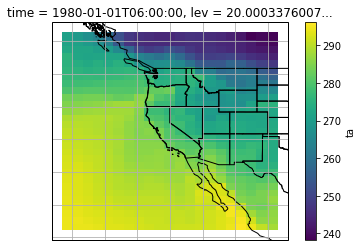

In [73]:
# Temperature
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds['ta'][0,0,:,:].plot(x='lon', y='lat',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})
ax.coastlines();ax.gridlines();ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')

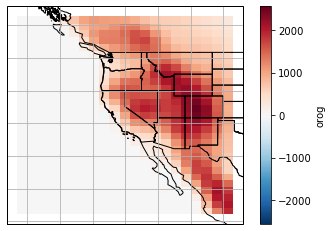

In [75]:
# Terrain Height
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds['orog'][:,:].plot(x='lon', y='lat',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})
ax.coastlines();ax.gridlines();ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')

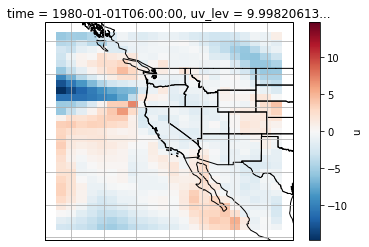

In [77]:
# U Winds
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds['u'][0,0,:,:].plot(x='lon_ua', y='lat_ua',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})
ax.coastlines();ax.gridlines();ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')

In [ ]:
# Extra Info
print("    Latitude")
print("")
print("vads and uads grid increases in latitude by 1.25°")
print("")
print("vads lat grid starts at 20.62°, uads lat grid starts at 20°,\nslice initiated at 20°")
print("")
print("vads and uads latitudes differ by 0.625° "+ \
      "\nwhich is 1/2 of the increase in latitude")
print("")

print("    Longitude")
print("")
print("vads and uads grid increases in longitude by 1.875°")
print("")
print("vads lon grid starts at 221.2°, uads lon grid starts at 220.3°,\nslice initiated at 220°")
print("")
print("vads and uads longitudes differ by 0.9375° "+ \
      "\nwhich is 1/2 of the increase in longitudes")
